In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input,Dense,SimpleRNN,Flatten,GRU,LSTM,GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam
from sklearn.preprocessing import StandardScaler

In [ ]:
df=pd.read_csv("sbux.csv")
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
#start by doing wrong thing-trying to predict the price itslef
series=df['close'].values.reshape(-1,1)

In [ ]:
#normalize the data
#note: don't think about where true boundary is, this is just approx
scaler=StandardScaler()
scaler.fit(series[:len(series)//2])
series=scaler.transform(series).flatten()

In [ ]:
#build the dataset
#let's see if we can use T past values to predict the next values
T=10
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)
X=np.array(X).reshape(-1,T,1)#data should be NxTxD
Y=np.array(Y)
N=len(X)
print(X.shape,Y.shape)

(1249, 10, 1) (1249,)


In [ ]:
#try autoregressive RNN
i=Input(shape=(T,1))
x=LSTM(5)(i)
x=Dense(1)(x)
model=Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(lr=0.1)

)
    

In [ ]:

r=model.fit(X[:-N//2],Y[:-N//2],validation_data=(X[:-N//2],Y[:-N//2]),epochs=80)

Epoch 1/80
20/20 [==============================] - 5s 46ms/step - loss: 0.8846 - val_loss: 0.7939
Epoch 2/80
20/20 [==============================] - 0s 13ms/step - loss: 0.7233 - val_loss: 0.6443
Epoch 3/80
20/20 [==============================] - 0s 13ms/step - loss: 0.5846 - val_loss: 0.5189
Epoch 4/80
20/20 [==============================] - 0s 12ms/step - loss: 0.4683 - val_loss: 0.4153
Epoch 5/80
20/20 [==============================] - 0s 12ms/step - loss: 0.3717 - val_loss: 0.3255
Epoch 6/80
20/20 [==============================] - 0s 12ms/step - loss: 0.2882 - val_loss: 0.2497
Epoch 7/80
20/20 [==============================] - 0s 15ms/step - loss: 0.2188 - val_loss: 0.1862
Epoch 8/80
20/20 [==============================] - 0s 12ms/step - loss: 0.1641 - val_loss: 0.1372
Epoch 9/80
20/20 [==============================] - 0s 12ms/step - loss: 0.1221 - val_loss: 0.1056
Epoch 10/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0961 - val_loss: 0.0884
Epoch 11/

Text(0, 0.5, 'loss')

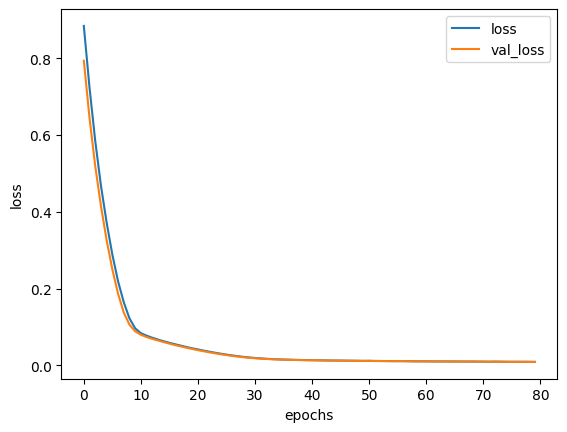

In [ ]:
plt.plot(r.history['loss'],label="loss")
plt.plot(r.history['val_loss'],label="val_loss")
plt.legend(loc=0)
plt.xlabel("epochs")
plt.ylabel("loss")

40/40 [==============================] - 1s 5ms/step


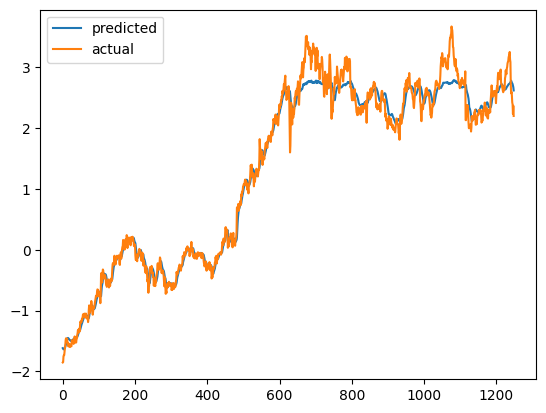

In [ ]:
#one step forecast using true target
output=model.predict(X)
plt.plot(output,label="predicted")
plt.plot(Y,label="actual")
plt.legend()

In [ ]:
#multistep forcast
#forecast future values (use only self predictions for the making future predictions)
validation_target=Y[-N//2:]
validation_predict=[]
#last train input
last_x=X[-N//2]
while len(validation_predict)<len(validation_target):
  p=model.predict(last_x.reshape(1,T,1))[0,0]#1x1 array
  #update the prediction_list
  validation_predict.append(p)
  #make the new input
  last_x=np.roll(last_x,-1)
  last_x[-1]=p

1/1 [==============================] - 0s 25ms/step


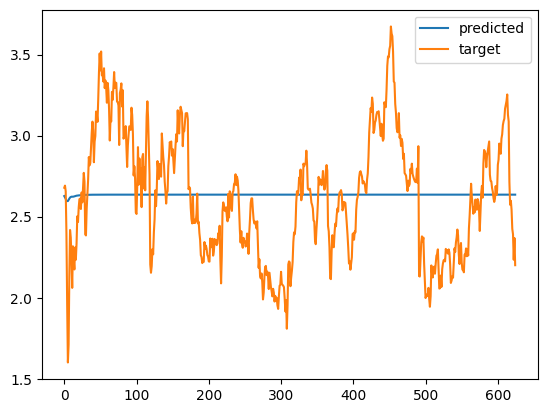

In [ ]:

plt.plot(validation_predict,label="predicted")
plt.plot(validation_target,label="target")
plt.legend()


In [ ]:
#calculate return by first shifting the data 
df['PrevClose']=df['close'].shift(1)#move everything up
#now it's like 
#close/prevclose
#x[2] x[1]
#x[3] x[2]
#x[4] x[3]
#x[t] x[t-1]

In [ ]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [ ]:
#then the return is 
#(x[t] -x[t-1])/x[t-1]
df['Return']=(df['close']-df['PrevClose'])/df["PrevClose"]
df.head()

,date,open,high,low,close,volume,Name,PrevClose,return,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015,-0.005015


<Axes: >

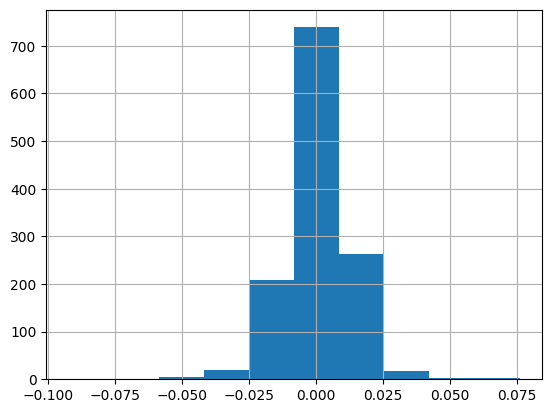

In [ ]:
#now lest try LSTM to predict returns 
df['Return'].hist()

In [ ]:
#normalize the data
series=df['Return'].values[1:].reshape(-1,1)
scaler=StandardScaler()
scaler.fit(series[:len(series)//2])
series=scaler.transform(series).flatten()


In [ ]:
#build the dataset
#let's see if we can use T past values to predict the next values
T=10
D=1
X=[]
Y=[]
for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)
X=np.array(X).reshape(-1,T,1)#data should be NxTxD
Y=np.array(Y)
N=len(X)
print(X.shape,Y.shape)

(1248, 10, 1) (1248,)


In [ ]:
#autoregressive RNN model#try autoregressive RNN
i=Input(shape=(T,1))
x=LSTM(5)(i)
x=Dense(1)(x)
model=Model(i,x)
model.compile(
    loss="mse",
    optimizer=Adam(lr=0.01)

)
    

In [ ]:

r=model.fit(X[:-N//2],Y[:-N//2],validation_data=(X[:-N//2],Y[:-N//2]),epochs=80)

Epoch 1/80
20/20 [==============================] - 6s 42ms/step - loss: 1.0526 - val_loss: 1.0441
Epoch 2/80
20/20 [==============================] - 0s 11ms/step - loss: 1.0402 - val_loss: 1.0342
Epoch 3/80
20/20 [==============================] - 0s 11ms/step - loss: 1.0304 - val_loss: 1.0266
Epoch 4/80
20/20 [==============================] - 0s 12ms/step - loss: 1.0233 - val_loss: 1.0197
Epoch 5/80
20/20 [==============================] - 0s 13ms/step - loss: 1.0174 - val_loss: 1.0141
Epoch 6/80
20/20 [==============================] - 0s 12ms/step - loss: 1.0121 - val_loss: 1.0096
Epoch 7/80
20/20 [==============================] - 0s 12ms/step - loss: 1.0084 - val_loss: 1.0055
Epoch 8/80
20/20 [==============================] - 0s 11ms/step - loss: 1.0044 - val_loss: 1.0026
Epoch 9/80
20/20 [==============================] - 0s 15ms/step - loss: 1.0016 - val_loss: 1.0002
Epoch 10/80
20/20 [==============================] - 0s 16ms/step - loss: 0.9992 - val_loss: 0.9974
Epoch 11/

Text(0, 0.5, 'loss')

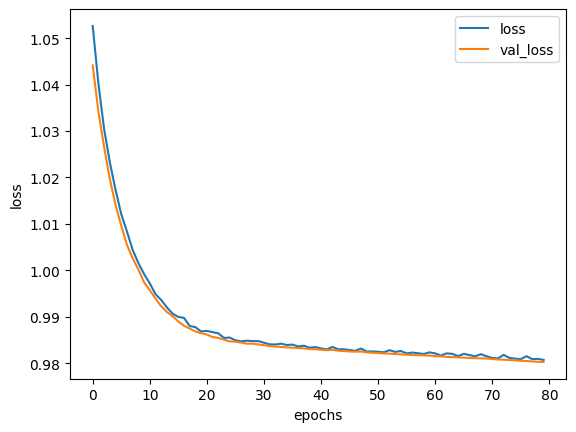

In [ ]:
plt.plot(r.history['loss'],label="loss")
plt.plot(r.history['val_loss'],label="val_loss")
plt.legend(loc=0)
plt.xlabel("epochs")
plt.ylabel("loss")

39/39 [==============================] - 3s 10ms/step


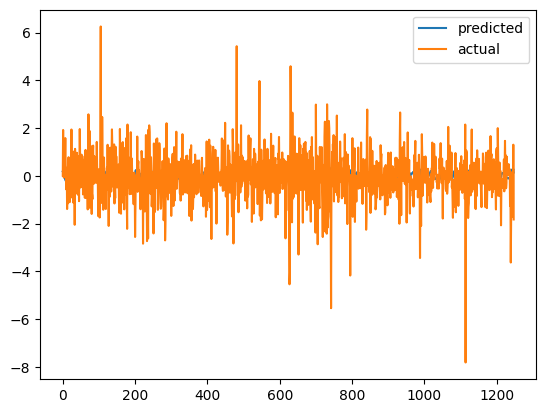

In [ ]:
output=model.predict(X)
plt.plot(output,label="predicted")
plt.plot(Y,label="actual")
plt.legend()
     

In [ ]:
#multistep forcast
#forecast future values (use only self predictions for the making future predictions)
validation_target=Y[-N//2:]
validation_predict=[]
#last train input
last_x=X[-N//2]
while len(validation_predict)<len(validation_target):
  p=model.predict(last_x.reshape(1,T,1))[0,0]#1x1 array
  #update the prediction_list
  validation_predict.append(p)
  #make the new input
  last_x=np.roll(last_x,-1)
  last_x[-1]=p

1/1 [==============================] - 0s 29ms/step


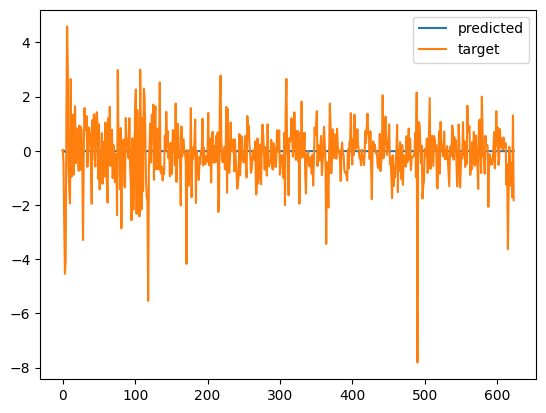

In [ ]:
plt.plot(validation_predict,label="predicted")
plt.plot(validation_target,label="target")
plt.legend()

In [58]:
# now from LSTMS
#turn the full dataset into numpy array
#now yet in the final "X" format
input_data=df[['open','high','low','close','volume']].values
target=df['Return'].values

In [61]:
#now make the actual data
T=10 # no of time steps to look at to make predictions for the next day
D=input_data.shape[1]
N=len(input_data)-T


In [62]:
#normalize the input
Ntrain=len(input_data)*2//3
scaler=StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data=scaler.transform(input_data)

In [63]:
x_train=np.zeros((Ntrain,T,D))
y_train=np.zeros(Ntrain)
for t in range(Ntrain):
  x_train[t,:,:]=input_data[t:t+T]
  y_train[t]=(target[t+T]>0)

  

In [65]:
#setup x_test and y_test
x_test=np.zeros((N-Ntrain,T,D))
y_test=np.zeros(N-Ntrain)
for u in range(N-Ntrain):
  t=u+Ntrain
  x_test[u,:,:]=input_data[t:t+T]
  y_test[u]=(target[t+T]>0)

In [67]:
i=Input(shape=(T,D))
x=LSTM(50)(i)
x=Dense(1,activation='sigmoid')(x)
model=Model(i,x)
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.001),
    metrics=['accuracy']

)

In [69]:
r=model.fit(x_train,y_train,batch_size=32,validation_data=(x_test,y_test),epochs=300)

Epoch 1/300
27/27 [==============================] - 7s 56ms/step - loss: 0.6957 - accuracy: 0.5113 - val_loss: 0.6930 - val_accuracy: 0.5146
Epoch 2/300
27/27 [==============================] - 0s 18ms/step - loss: 0.6937 - accuracy: 0.5137 - val_loss: 0.7002 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 1s 20ms/step - loss: 0.6920 - accuracy: 0.5173 - val_loss: 0.6919 - val_accuracy: 0.5366
Epoch 4/300
27/27 [==============================] - 0s 18ms/step - loss: 0.6941 - accuracy: 0.5113 - val_loss: 0.6951 - val_accuracy: 0.4854
Epoch 5/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6914 - accuracy: 0.5292 - val_loss: 0.6936 - val_accuracy: 0.5049
Epoch 6/300
27/27 [==============================] - 0s 14ms/step - loss: 0.6914 - accuracy: 0.5256 - val_loss: 0.6930 - val_accuracy: 0.5049
Epoch 7/300
27/27 [==============================] - 0s 12ms/step - loss: 0.6894 - accuracy: 0.5340 - val_loss: 0.6945 - val_accuracy: 0.5049
Epoch 

Text(0, 0.5, 'loss')

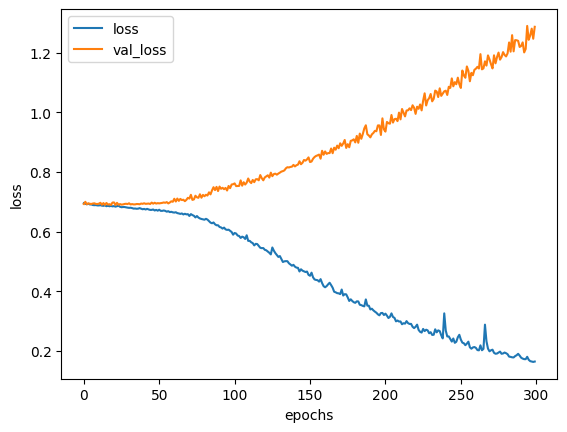

In [70]:

plt.plot(r.history['loss'],label="loss")
plt.plot(r.history['val_loss'],label="val_loss")
plt.legend(loc=0)
plt.xlabel("epochs")
plt.ylabel("loss")
     

13/13 [==============================] - 2s 7ms/step


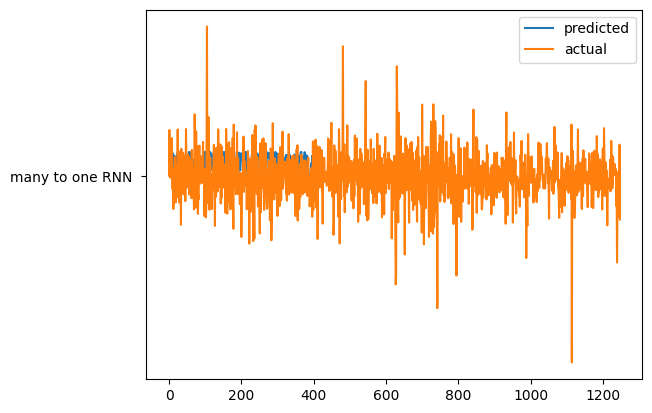

In [72]:
#one step forcast using true
output=model.predict(x_test
)
output.shape
predictions=output[:,0]
plt.plot(predictions,label="predicted")
plt.plot(Y,label="actual")
plt.plot("many to one RNN ")
plt.legend()